# Document Redaction with Azure AI Language PII Native Document Analysis

**Before running this notebook, ensure you have selected the correct Python kernel. If running in the `devcontainer` environment, this is likely to be 3.12.11 at `/usr/local/python/current/bin/python`.**

![Example devcontainer notebook kernel](../../../images/python-notebook-kernel.png)

This sample demonstrates how to use the Azure AI Language service to redact any Personally Identifiable Information (PII) from a provided PDF document using the preview **Native Document Support** features. You can find more information on these new capabilities in [our documentation for analyzing native documents](https://learn.microsoft.com/en-us/azure/ai-services/language-service/native-document-support/use-native-documents?tabs=pii).

> **IMPORTANT**: This feature only supports documents that are digitized (i.e. non-scanned documents) in `.txt`, `.docx`, or `.pdf` format. If you are working with scanned documents, explore the [document redaction with Azure OpenAI sample](./document-redaction-gpt.ipynb).

![Data Redaction](../../../images/redaction-language-pii.png)

This is achieved by the following process:

- Ensure that your prepared documents are uploaded to an Azure Blob Storage container, in `.txt`, `.docx`, or `.pdf` format, that the Azure AI Language service can access. 
  - For keyless authentication using Azure RBAC, ensure that you [grant storage account access to your Azure AI service resource](https://learn.microsoft.com/en-us/azure/ai-services/language-service/native-document-support/managed-identities#grant-storage-account-access-for-your-language-resource). 
  - _Note_: Infrastructure deployed by this sample repository automatically provides the necessary role assignments for the Azure AI service to access the storage account.
- Analyze the document by calling the `analyze-documents/jobs` endpoint with a PII redaction task payload.
- Retrieve the redacted document from the Azure Blob Storage container output.

## Use Cases

- Pre-processing of documents for compliance with data privacy regulations ahead of downstream processing (e.g., classification, extraction, summarization, translation, etc.)

## Objectives

By the end of this sample, you will have learned how to:

- Prepare a document for redaction by uploading it to an Azure Blob Storage container.
- Redact PII from the document using the Azure AI Language service.

## Useful Tips

- Combine this technique with a [document classification](../classification/README.md) approach to determine if the document contains PII before redaction.
- You can also combine this technique with a post-processing [document data extraction](../extraction/README.md) approach to extract specific information from the document after redaction.

## Setup

### Import modules

This sample takes advantage of the following Python dependencies:

- **azure-storage** to interface with an Azure Blob Storage container.
- **azure-identity** to securely authenticate with deployed Azure services using Microsoft Entra ID credentials.
- **pdf2image** to display the final redacted document in the sample notebook.

The following local components are also used:

- [**language_native_pii_client**](../modules/samples/language/language_native_pii_client.py) to interact with the Azure AI Language service for Native Document PII redaction. 
  - _Note: This class has been created as a wrapper around HTTP requests, as the SDK does not yet support the Native Document PII redaction feature._
- [**stopwatch**](../modules/samples/utils/stopwatch.py) to measure the end-to-end execution time for the redaction process.
- [**app_settings**](../modules/samples/app_settings.py) to access environment variables from the `.env` file.

In [18]:
import sys
sys.path.append('../modules/') # Import local modules

from IPython.display import display, Markdown
import os
from dotenv import dotenv_values
import json
from azure.storage.blob import BlobServiceClient
from azure.identity import DefaultAzureCredential
from pdf2image import convert_from_bytes

from samples.app_settings import AppSettings
from samples.utils.stopwatch import Stopwatch
from samples.utils.storage_utils import create_data_file

from samples.language.language_native_pii_client import LanguageNativePIIClient # Custom Azure AI Language client to handle preview native document features

### Configure the Azure services

To use the preview Native Document PII redaction feature of Azure AI Language, the `LanguageNativePIIClient` custom wrapper is used to interact with the service. The client setup mimics the approach to Azure official SDKs (i.e., requires an Azure AI Language service endpoint and a token credential).

To access the Azure Storage account, the Python SDK is used to create client instances using a deployed storage account name and authentication credentials.

For this sample, the credentials of the Azure CLI are used to authenticate with the deployed services.

In [ ]:
# Set the working directory to the root of the repo
working_dir = os.path.abspath('../../../')
settings = AppSettings(dotenv_values(f"{working_dir}/.env"))
sample_path = f"{working_dir}/samples/python/redaction"
sample_name = "document-redaction-language-native-document"

# Configure the default credential for accessing Azure services using Azure CLI credentials
credential = DefaultAzureCredential(
    exclude_workload_identity_credential=True,
    exclude_developer_cli_credential=True,
    exclude_environment_credential=True,
    exclude_managed_identity_credential=True,
    exclude_powershell_credential=True,
    exclude_shared_token_cache_credential=True,
    exclude_interactive_browser_credential=True
)

language_native_pii_client = LanguageNativePIIClient(
    endpoint=settings.azure_ai_services_endpoint,
    credential=credential
)

storage_account_name = settings.azure_storage_account_name

blob_service_client = BlobServiceClient(
    account_url=f"https://{storage_account_name}.blob.core.windows.net",
    credential=credential
)

## Prepare the document for redaction

To redact PII from a document, the document must first be uploaded to an Azure Blob Storage container. The document must be in `.txt`, `.docx`, or `.pdf` format.

For this sample, an [Invoice](../../assets/invoices/invoice_1.pdf) is used as the document to be redacted.

> **Note**: When using keyless authentication with Azure Storage accounts, the Azure AI service must be granted access to the storage account. This is done by assigning the `Storage Blob Data Contributor` role to the Azure AI service to allow the AI service to retrieve and create documents in the storage account.

In [20]:
path = f"{working_dir}/samples/assets/invoices/"
metadata_fname = "invoice_2.json"  # Change this to the file you want to evaluate
metadata_fpath = f"{path}{metadata_fname}"

# Load the metadata from the JSON file
with open(metadata_fpath, "r") as f:
    data = json.load(f)

# Extract the PDF file name and path from the metadata
pdf_fname = data['fname']
pdf_fpath = f"{path}{pdf_fname}"

In [21]:
blob_container_name = "redaction-samples"
input_blob_container_folder = "raw"
output_blob_container_folder = "processed"

# Create the sample blob container if it doesn't exist
blob_container_client = blob_service_client.get_container_client(blob_container_name)
if not blob_container_client.exists():
    blob_container_client.create_container()
    
# Upload the sample PDF file to the blob container in the input folder
input_blob_client = blob_container_client.get_blob_client(f"{input_blob_container_folder}/{pdf_fname}")

with open(pdf_fpath, "rb") as data:
    input_blob_client.upload_blob(data, overwrite=True)

## Redact PII from the document

To redact PII from the document, the Azure AI Language service is used to analyze the document and redact any PII found.

The following code blocks initiate the analysis process by preparing a redaction task payload and calling the `analyze-documents/jobs` endpoint of the Azure AI Language service.

The redaction task payload is defined as follows:

```json
{ 
    "displayName": "<Your Job Name>", 
    "analysisInput": { 
        "documents": [ 
            { 
                "language": "en", // The language code for the document.
                "id": "Doc-1", // A user-defined unique ID for the document. 
                "source": { 
                    "location": "https://<Your Storage Account Name>.blob.core.windows.net/<Your Container Name>/<Your Document Name>.pdf"
                }, 
                "target": { 
                    "location": "https://<Your Storage Account Name>.blob.core.windows.net/<Your Container Name>/redacted"
                }
            } 
        ] 
    }, 
    "tasks": [ 
        { 
            "kind": "PiiEntityRecognition", 
            "taskName": "Redact PII", // A user-defined name for the task to run. 
            "parameters": { 
                "redactionPolicy": { 
                    "policyKind": "entityMask"  // Optional. Defines redactionPolicy; changes behavior based on value. Options: noMask, characterMask (default), and entityMask. 
                }, 
                "piiCategories": [ 
                    "Person", 
                    "Organization" 
                ],  // Optional. Defines the PII categories to redact.
                "excludeExtractionData": false  // Default is false. If true, only the redacted document is stored, without extracted entities data. 
            } 
        } 
    ] 
} 
```

> **Note**: The `piiCategories` field is optional and can be used to specify the PII categories to redact. If not specified, all PII categories are redacted. You can find more information about the PII categories in the [Azure AI Language documentation](https://learn.microsoft.com/en-us/rest/api/language/text-analysis-runtime/analyze-text?view=rest-language-2024-11-01&tabs=HTTP#piicategory).

In [27]:
with Stopwatch() as pii_stopwatch:
    result = language_native_pii_client.begin_analyze_document(
        analyze_request={ 
            "displayName": "Document PII Redaction example", 
            "analysisInput": { 
                "documents": [ 
                    { 
                        "language": "en", 
                        "id": pdf_fname,
                        "source": { 
                            "location": f"https://{storage_account_name}.blob.core.windows.net/{blob_container_name}/{input_blob_container_folder}/{pdf_fname}"
                        }, 
                        "target": { 
                            "location": f"https://{storage_account_name}.blob.core.windows.net/{blob_container_name}/{output_blob_container_folder}"
                        } 
                    } 
                ] 
            }, 
            "tasks": [ 
                { 
                    "kind": "PiiEntityRecognition", 
                    "taskName": "Redact PII", 
                    "parameters": { 
                        "redactionPolicy": { 
                            "policyKind": "characterMask"
                        }, 
                        "piiCategories": [
                            "Person",
                            "PhoneNumber",
                            "Address",
                            "Email"
                        ],
                        "excludeExtractionData": True
                    } 
                } 
            ] 
        })

## Visualize the outputs

To provide context for the execution of the code, the following code blocks visualize the outputs of the redaction process.

This includes:

- The contents of the redacted document.
- The execution time of the redaction process.

In [28]:
# Gets the total execution time of the redaction process.
total_elapsed = pii_stopwatch.elapsed

display(Markdown(f"**Total Elapsed Time:** {total_elapsed}"))

**Total Elapsed Time:** 18.162711299955845

In [29]:
# Download the blob PDF file with the redacted PII
redacted_pdf_url = result.tasks.items[0].results.documents[0].targets[0].location
redacted_blob_path = redacted_pdf_url.split(f"https://{storage_account_name}.blob.core.windows.net/{blob_container_name}/")[1]

redacted_blob_client = blob_container_client.get_blob_client(redacted_blob_path)
redacted_blob_downloader = redacted_blob_client.download_blob()

# Save the redacted PDF file locally
redacted_pdf_fpath = f"{sample_path}/{sample_name}_redacted_{pdf_fname}"

create_data_file(redacted_pdf_fpath, redacted_blob_downloader.readall())

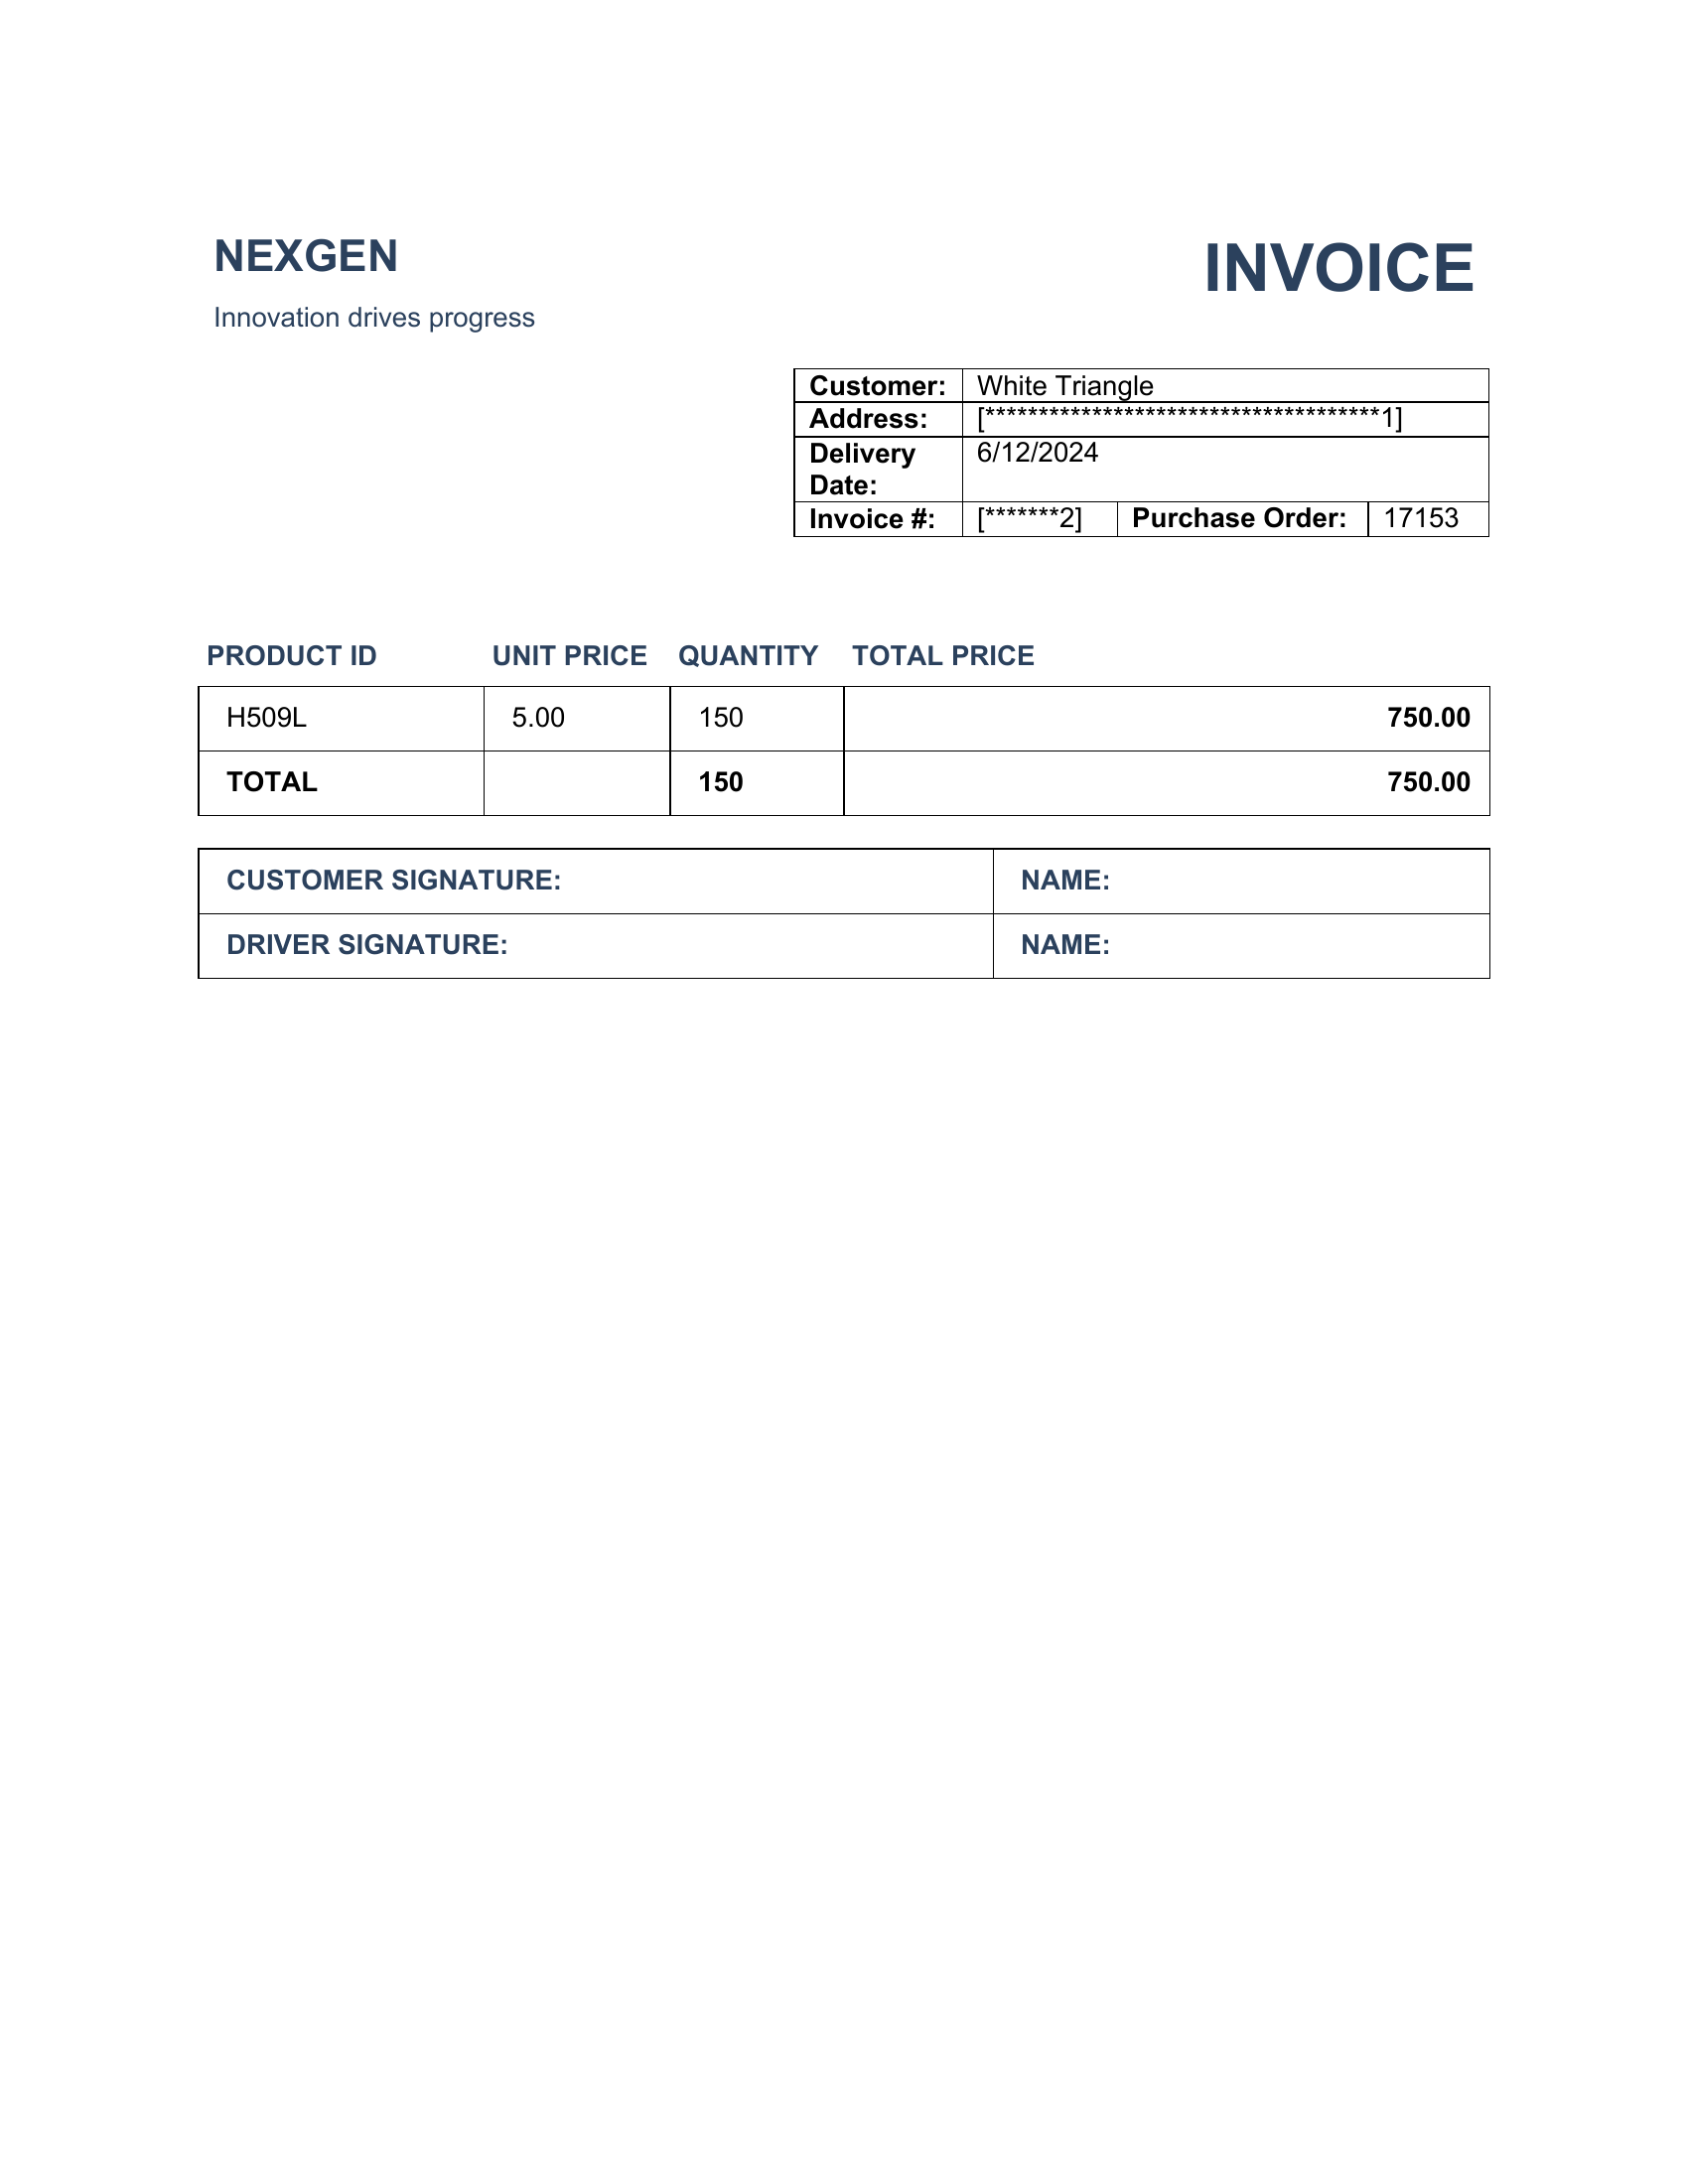

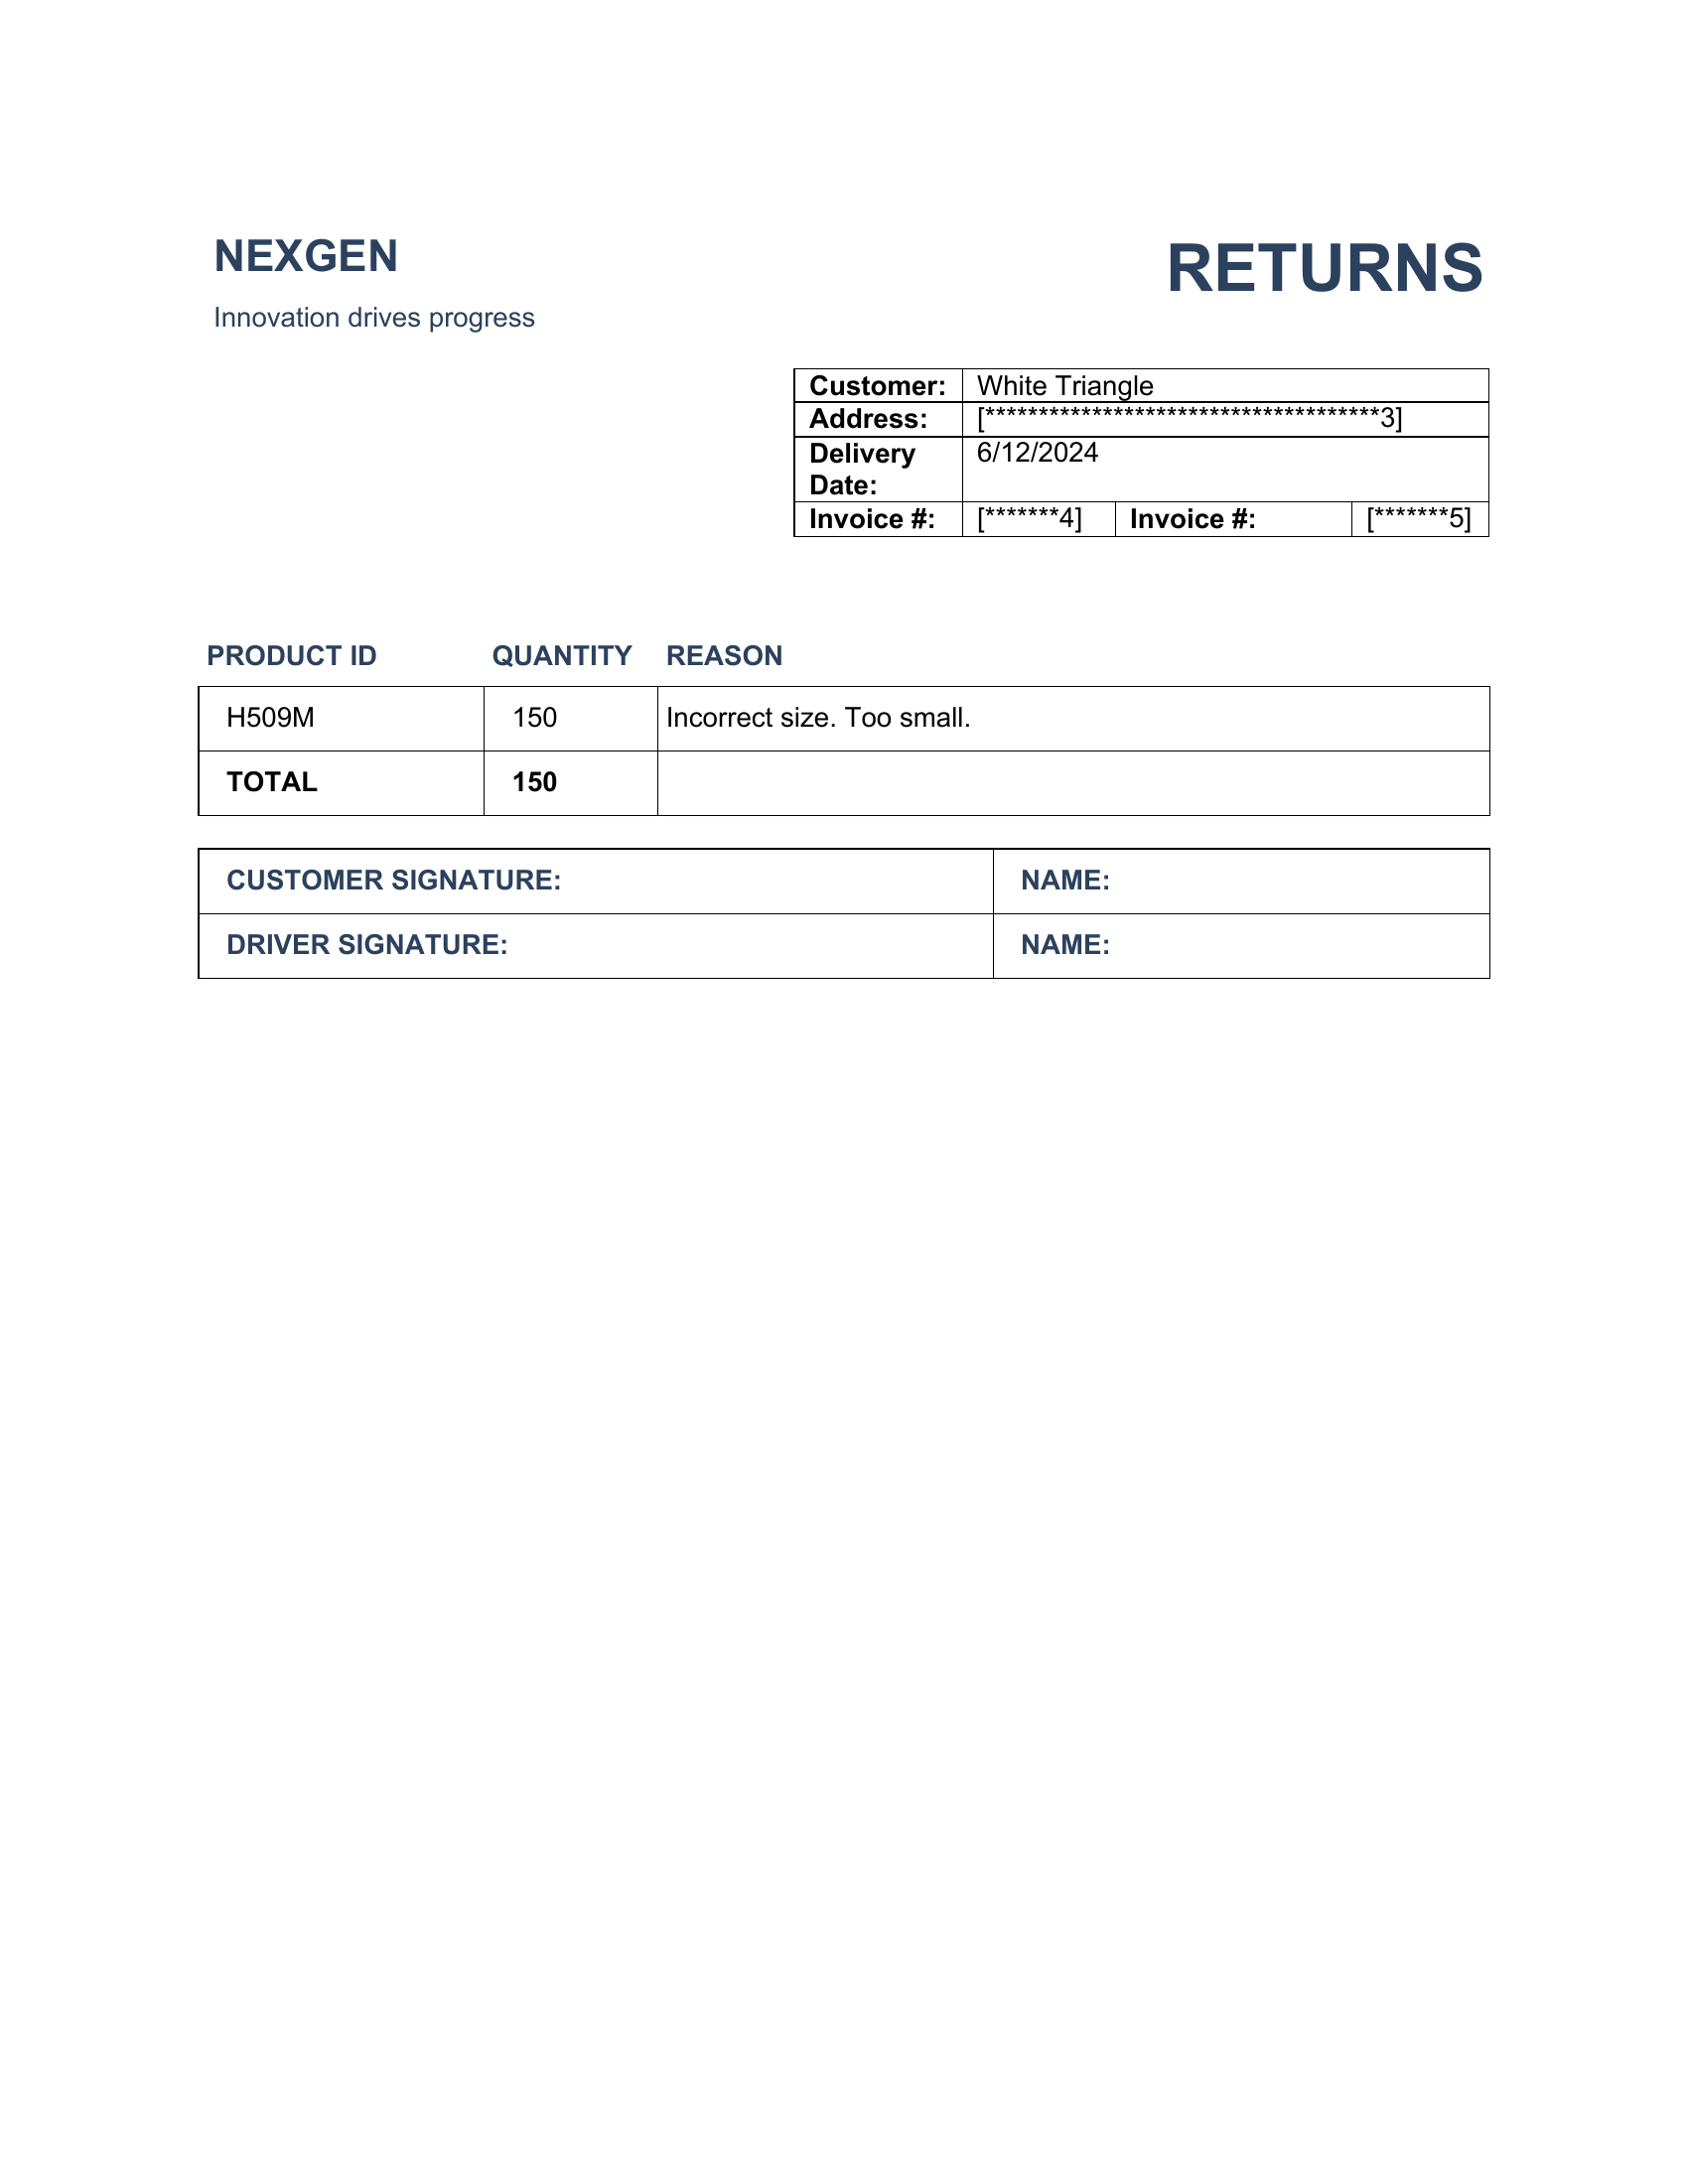

In [30]:
# Display the redacted PDF file as images
document_bytes = open(redacted_pdf_fpath, "rb").read()
page_images = convert_from_bytes(document_bytes)

for i, page_image in enumerate(page_images):
    display(page_image)